In [1]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
import json
import sys
import os
import re
import pprint
import time
import copy
from bs4 import BeautifulSoup
import seaborn as sn
from scipy.stats import skew, skewtest

%matplotlib inline

In [2]:
df = pd.read_csv("./twitter_archive_master.csv", header=0,
                 names=["ID", "CreateTime", "Device",
                         "Tweet", "RetweetTime", "TweetUrl",
                         "RatingNumerator", "RatingDenominator",
                         "DogName", "DogType", "ImgUrl1", "ImgNum",
                         "Pred1", "PredConf1", "PredResult1", 
                         "Pred2", "PredConf2", "PredResult2",
                         "Pred3", "PredConf3", "PredResult3",
                         "ImgUrl2", "FavoriteCount", "RetweetCount"],
                 converters={"CreateTime": pd.Timestamp,
                              "RetweetTime": pd.Timestamp,
                              "PredResult1": bool,
                              "PredResult2": bool,
                              "PredResult3": bool})

In [3]:
df = df[["ID", "CreateTime", "DogName", "DogType", 
         "RatingNumerator", "RatingDenominator",
        "FavoriteCount", "RetweetCount", "RetweetTime",
         "Device", "ImgUrl1", "ImgUrl2", "ImgNum","Tweet", 
         "TweetUrl","Pred1", "PredConf1", "PredResult1", 
         "Pred2", "PredConf2", "PredResult2", "Pred3", 
        "PredConf3", "PredResult3"]]

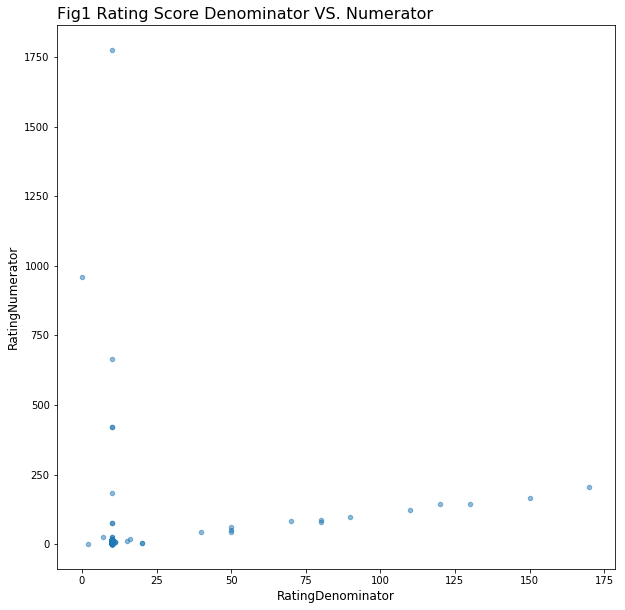

In [4]:
df.plot(x="RatingDenominator", y="RatingNumerator", kind="scatter", figsize=(10, 10), alpha=0.5, fontsize=10)
plt.title("Fig1 Rating Score Denominator VS. Numerator", loc="left", fontsize=16)
plt.xlabel("RatingDenominator", fontsize=12)
plt.ylabel("RatingNumerator", fontsize=12)
plt.show()

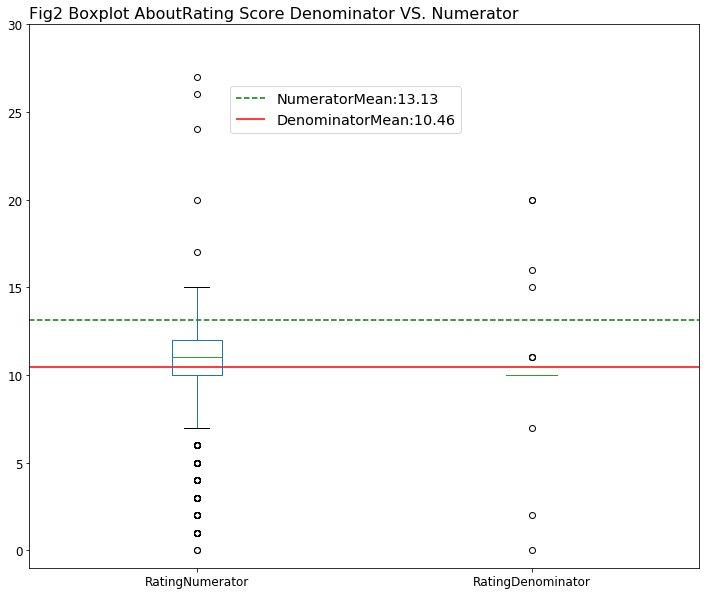

In [5]:
df[["RatingNumerator", "RatingDenominator"]].plot(kind="box", ylim=(-1, 30), figsize=(12, 10),fontsize=12)
plt.hlines(y=df["RatingNumerator"].mean(), xmin=0, xmax=3, 
           linestyles="--", color="g", label="NumeratorMean:%s"% round(df["RatingNumerator"].mean(), 2))

plt.hlines(y=df["RatingDenominator"].mean(), xmin=0, xmax=3, 
           linestyles="-", color="r", label="DenominatorMean:%s"% round(df["RatingDenominator"].mean(), 2))
plt.legend(fontsize="x-large", loc=(0.3, 0.8))

plt.title("Fig2 Boxplot AboutRating Score Denominator VS. Numerator", loc="left", fontsize=16)
plt.show()

In [6]:
skew(df[["RatingNumerator", "RatingDenominator"]])

array([29.75146963, 17.14143524])

In [7]:
df[["RatingNumerator", "RatingDenominator"]].corr()

,RatingNumerator,RatingDenominator
RatingNumerator,1.000000,0.150388
RatingDenominator,0.150388,1.000000


In [8]:
df[df["RatingNumerator"]<250][["RatingNumerator", "RatingDenominator"]].corr()

,RatingNumerator,RatingDenominator
RatingNumerator,1.000000,0.854158
RatingDenominator,0.854158,1.000000


## 评分数据分析
未对评分数据进行处理的情况下，1）从散点图中可以看出，`RatingNumerator` 部分值得分过于高，`RatingDenominator` 也存在部分值偏斜。从统计分析偏斜度来看，两者的偏斜度分别是——前者为 `29.75`，后者为 `17.14`；2）`RatingDenominator` 的数据相对分布均匀；3）两者的皮尔逊相关系数为 `0.1504`，两者的相关性统计学上较低。

在对 `RatingNumerator` 的数据超过 `250` 的值进行清理后，在进行了一次皮尔逊相关系数分析，此次得到的值为 `0.8542` ——明显相关性增加了很多

In [9]:
df["CreateDate"] = df["CreateTime"].dt.date
group_ = df.groupby("CreateDate")
group_data = pd.concat([group_["ID"].count(), group_["FavoriteCount"].sum(), group_["RetweetCount"].sum()], axis=1)

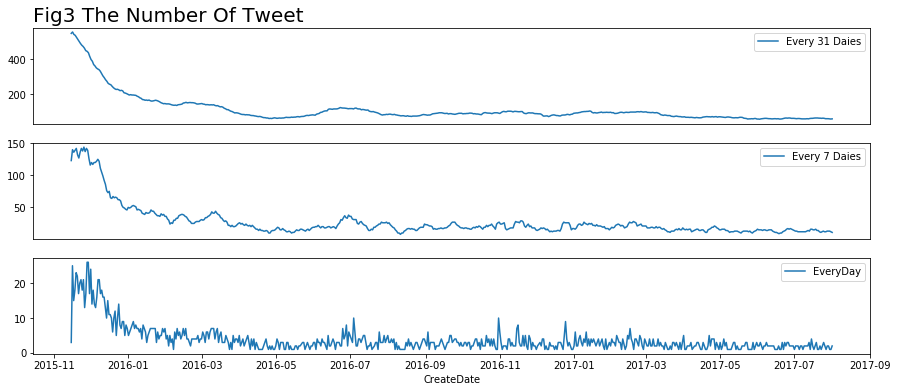

In [10]:
plt.subplot(3, 1, 1)
ax = group_data["ID"].rolling(31).sum().plot(figsize=(15, 6), label="Every 31 Daies", use_index=False)
plt.legend()
plt.title("Fig3 The Number Of Tweet", loc="left", fontsize=20)
ax.set_xticklabels("")
ax.set_xticks([])

plt.subplot(3, 1, 2)
ax = group_data["ID"].rolling(7).sum().plot(figsize=(15, 6), label="Every 7 Daies", use_index=False)
plt.legend()
ax.set_xticklabels("")
ax.set_xticks([])

plt.subplot(3, 1, 3)
group_data["ID"].plot(figsize=(15, 6), label="EveryDay")
plt.legend()

plt.show()

## 用户发送信息分析
`Fig3` 展示的是用户 [@dog_rates](https://twitter.com/dog_rates) 随着时间变化发送 `Tweet` 的数量变化，以及分别对数据进行了移动求和处理。从以上的结果可以看出：

1. 总体上来看，该用户发 `Tweet` 的数量随着时间的变化，而逐渐减少。这点从每 7 天和每 31 天发送 `tweet` 的数量表现的比较明显
2. 即使总体上来看，该用户的在 2016 年 5 月之后发送的数量相对开始比较稳定。这可能是因为当其他用户对其信息产生黏性之后，对数量的依赖性表现的不是很明显。关于这点需要从用户点赞数量和转推数量方面去验证

/Users/renrui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/renrui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


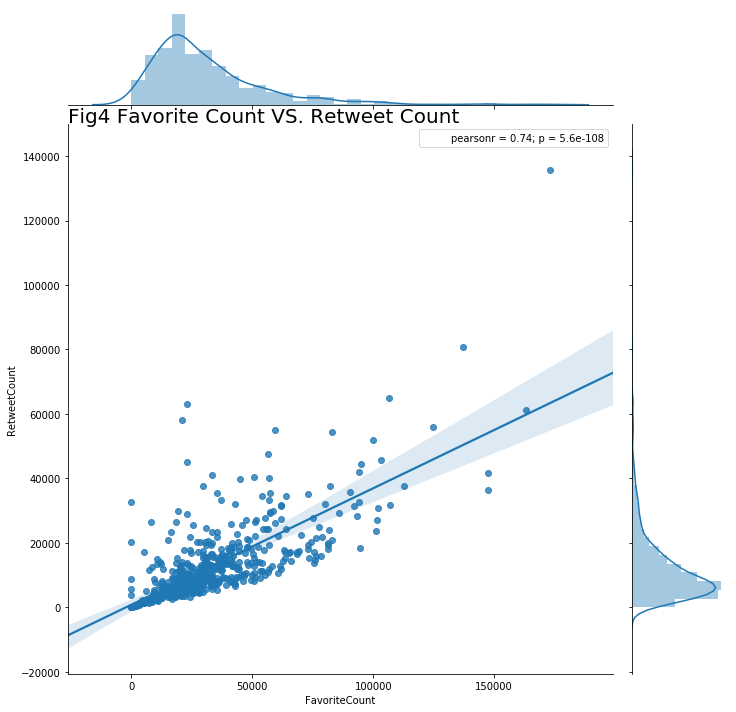

In [11]:
sn.jointplot(x="FavoriteCount", y="RetweetCount", data=group_data, kind="reg", size=10)


plt.title("Fig4 Favorite Count VS. Retweet Count", loc="left", fontsize=20, pad=2)
plt.show()

## 点赞数量和转推数量分析
从点赞数量和转推数量展示的结果 `Fig4`，可以提出以下结论：

1. 两者都是正偏态分布的数据
2. 两者进行拟合，得到的皮尔逊相关系数值为 `0.74`，且是有统计学显著性的。因此说明了在该用户下，点赞数量和转推数量呈现出较高的相关性

In [12]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS, OLSResults, GLS

In [13]:
outcome = group_data["FavoriteCount"]
independent_variable = group_data.drop("FavoriteCount", axis=1)
model = OLS(outcome, independent_variable)
results = model.fit()
print(results.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.793     
Dependent Variable: FavoriteCount    AIC:                13641.5907
Date:               2018-06-09 18:04 BIC:                13650.4111
No. Observations:   608              Log-Likelihood:     -6818.8   
Df Model:           2                F-statistic:        1167.     
Df Residuals:       606              Prob (F-statistic): 1.39e-208 
R-squared:          0.794            Scale:              3.2381e+08
-------------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|   [0.025    0.975] 
-------------------------------------------------------------------
ID              948.0982 166.5481  5.6926 0.0000 621.0167 1275.1796
RetweetCount      1.8885   0.0543 34.8093 0.0000   1.7819    1.9950
-------------------------------------------------------------------
Omnibus:             146.006       Durbin-Watson:          1.345  

## 线性拟合分析
最后以点赞数量作为自变量，而每日发 `tweet` 数量和 转推数量作为因变量进行线性拟合分析，采用的方法是使用了 `OLS` 方法进行分析。从最后的报告来看，得到了 ${R^2}$ 的值为 `0.794`，也即得到了比较高的相关性参数。从统计显著性结果来看，也是具有统计显著性的。